Dataset Head:
                                  Name  Year  Duration  \
0  #Gadhvi (He thought he was Gandhi)  2019       109   
1                             #Yaaram  2019       110   
2                ...Aur Pyaar Ho Gaya  1997       147   
3                           ...Yahaan  2005       142   
4                  ?: A Question Mark  2012        82   

                       Genre  Rating  Votes        Director          Actor 1  \
0                      Drama     7.0      8   Gaurav Bakshi     Rasika Dugal   
1            Comedy, Romance     4.4     35      Ovais Khan          Prateik   
2     Comedy, Drama, Musical     4.7    827    Rahul Rawail       Bobby Deol   
3        Drama, Romance, War     7.4   1086  Shoojit Sircar  Jimmy Sheirgill   
4  Horror, Mystery, Thriller     5.6    326   Allyson Patel        Yash Dave   

                  Actor 2          Actor 3  
0          Vivek Ghamande    Arvind Jangid  
1              Ishita Raj  Siddhant Kapoor  
2  Aishwarya Rai Bachchan 

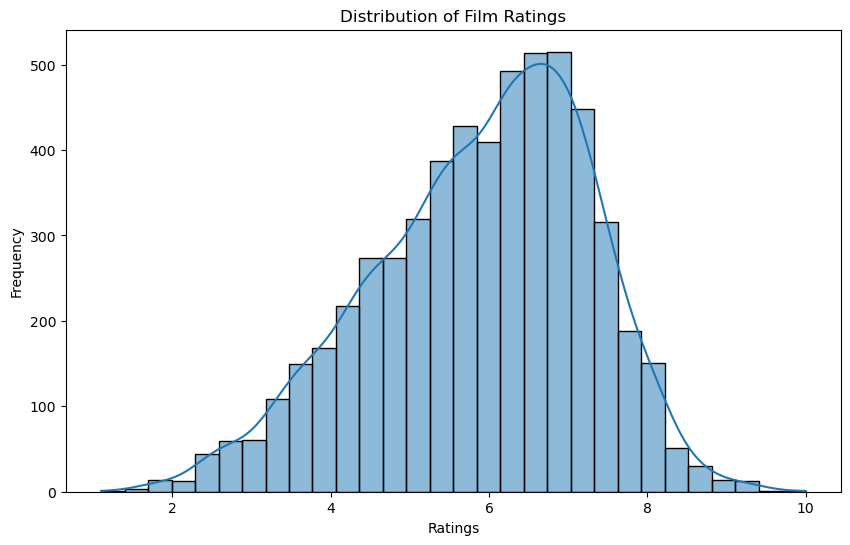

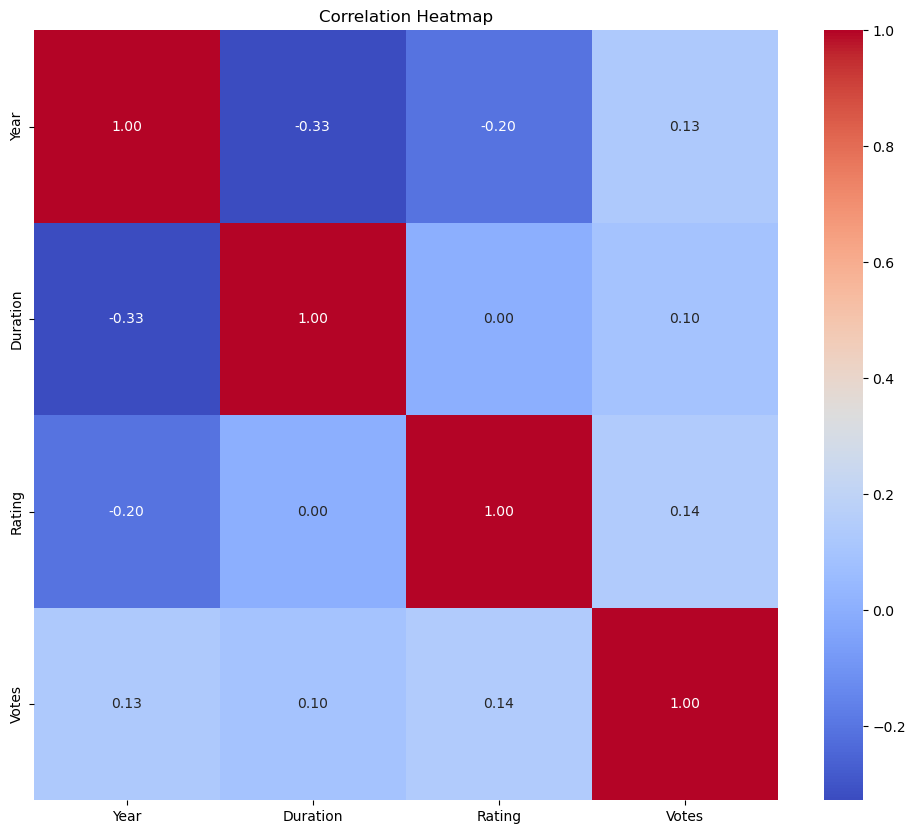

Remaining rows after dropping missing 'Rating': 5659
Fitting 5 folds for each of 144 candidates, totalling 720 fits


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Step 1: Load and inspect the dataset
data = pd.read_csv('movies_data.csv')
print("Dataset Head:\n", data.head())
print("\nDataset Info:\n")
data.info()

# Print available columns
print("Columns in the dataset:", data.columns.tolist())

# Step 2: Exploratory Data Analysis (EDA)
# Check distribution of ratings
plt.figure(figsize=(10, 6))
sns.histplot(data['Rating'], bins=30, kde=True)
plt.title('Distribution of Film Ratings')
plt.xlabel('Ratings')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap to identify relationships between features and target
# Ensure only numerical columns are considered for correlation
numerical_data = data.select_dtypes(include=[np.number])
plt.figure(figsize=(12, 10))
corr_matrix = numerical_data.corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()

# Step 3: Identify Target Column
# Adjust this if your target column has a different name
possible_targets = ['Rating', 'ratings', 'user_rating']
target_column = next((col for col in possible_targets if col in data.columns), None)

if not target_column:
    raise ValueError(
        f"The dataset does not contain any of the expected target columns: {possible_targets}. "
        f"Available columns are: {data.columns.tolist()}"
    )

# Drop rows where the target column is missing or null
if data[target_column].isnull().all():
    raise ValueError(f"The column '{target_column}' exists but contains only missing values.")

data = data.dropna(subset=[target_column])  # Drop rows with missing ratings
print(f"Remaining rows after dropping missing '{target_column}':", len(data))

# Step 4: Data Preprocessing
categorical_features = [col for col in ['genre', 'director', 'actors'] if col in data.columns]
numerical_features = [
    col for col in data.columns
    if data[col].dtype in ['int64', 'float64'] and col != target_column
]

# Fill missing values
for col in categorical_features:
    data[col].fillna('Unknown', inplace=True)

for col in numerical_features:
    data[col].fillna(data[col].mean(), inplace=True)

# Step 5: Define Features and Target
X = data[categorical_features + numerical_features]
y = data[target_column]

# Step 6: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Create Pipelines for Preprocessing
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

# Step 8: Model Selection and Training
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Step 9: Hyperparameter Tuning using GridSearchCV
param_grid = {
    'regressor__n_estimators': [50, 100, 150, 200],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Step 10: Evaluate the Best Model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Best Model Parameters: {grid_search.best_params_}")
print(f"Mean Squared Error: {mse}")
print(f"R^2 Score: {r2}")

# Step 11: Feature Importance Visualization
if hasattr(best_model.named_steps['regressor'], 'feature_importances_'):
    feature_names = numerical_features + list(
        best_model.named_steps['preprocessor'].transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
    )
    feature_importances = best_model.named_steps['regressor'].feature_importances_
    feature_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    feature_df = feature_df.sort_values(by='Importance', ascending=False)

    # Visualize feature importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_df.head(15))
    plt.title('Top 15 Feature Importances')
    plt.tight_layout()
    plt.show()

# Step 12: Visualize Results
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel('True Ratings')
plt.ylabel('Predicted Ratings')
plt.title('True vs Predicted Ratings')
plt.tight_layout()
plt.show()
